# Clustering Analysis

In this notebook we want to find out which customer groups exist. For this purpose we use clustering methods.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans

la_2018_set = pd.read_pickle("Data/la_2018_set.pickle")
feature_set = pd.read_pickle("Data/feature_set.pickle")
feature_set_daily = pd.read_pickle("Data/feature_set_daily.pickle")

In [20]:
k_max = 10  # more than 10 clusters are definitely
            # not reasonable!

In [21]:
X=feature_set.drop(columns =["day"], axis=1)

X.head()

,hour,trips,minutes_driven,max_temp,precip,is_weekday
0,0,25.0,738.0,14.4,0.0,1
1,1,24.0,1171.0,14.4,0.0,1
2,2,12.0,232.0,14.4,0.0,1
3,3,3.0,41.0,14.4,0.0,1
4,4,5.0,1463.0,14.4,0.0,1


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,hour,trips,minutes_driven,max_temp,precip,is_weekday
0,-1.720900,-0.402027,-0.471914,-0.897547,-0.126457,0.633137
1,-1.575046,-0.438841,-0.172196,-0.897547,-0.126457,0.633137
2,-1.429193,-0.880609,-0.822162,-0.897547,-0.126457,0.633137
3,-1.283339,-1.211935,-0.954371,-0.897547,-0.126457,0.633137
4,-1.137486,-1.138307,0.029924,-0.897547,-0.126457,0.633137


In [23]:
features_scaled = X_scaled_df
features_scaled.head()

,hour,trips,minutes_driven,max_temp,precip,is_weekday
0,-1.720900,-0.402027,-0.471914,-0.897547,-0.126457,0.633137
1,-1.575046,-0.438841,-0.172196,-0.897547,-0.126457,0.633137
2,-1.429193,-0.880609,-0.822162,-0.897547,-0.126457,0.633137
3,-1.283339,-1.211935,-0.954371,-0.897547,-0.126457,0.633137
4,-1.137486,-1.138307,0.029924,-0.897547,-0.126457,0.633137


In [24]:
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

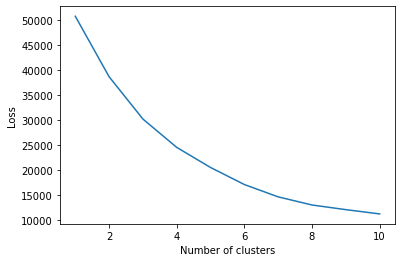

In [25]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 6.0)

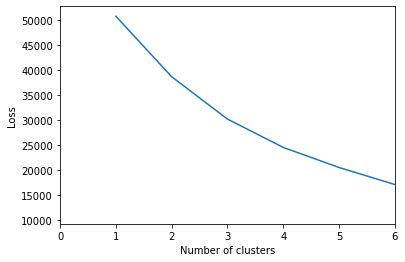

In [26]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,6])

In [27]:
# refit algorithm
two_means = KMeans(n_clusters=2)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

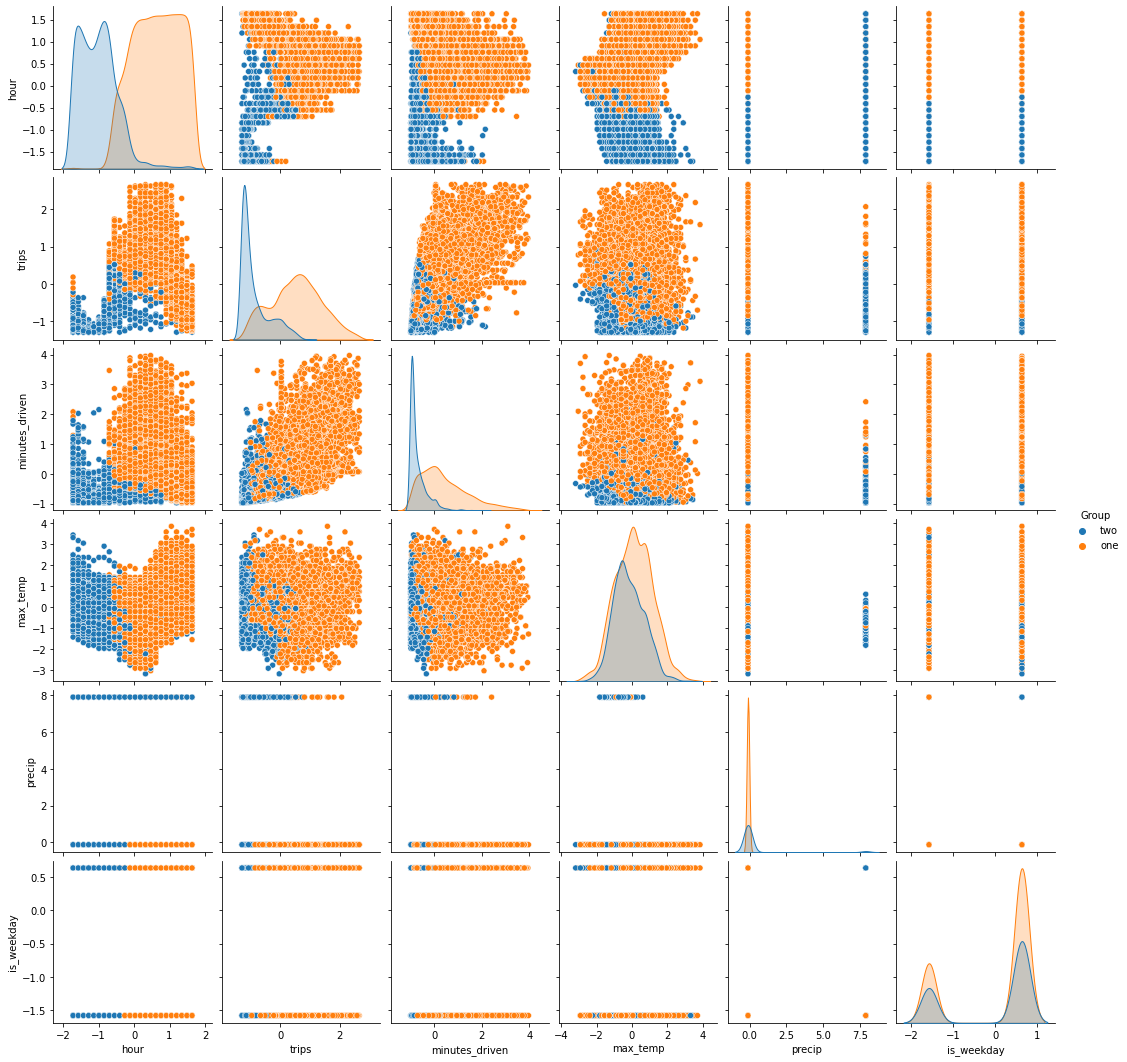

In [28]:
numbers = [ "one", "two", "three"]

features_scaled["Group"] = two_means.predict(X_scaled)
features_scaled["Group"] = features_scaled["Group"].apply(lambda x: numbers[x])
sns.pairplot(data=features_scaled, hue="Group")

We can see that the distinguishing of the bike company between a walk-up user and a Monthly-pass user makes sense. We observe two customer groups. Group one takes shorter and fewer trips (walk-up user) and group two takes longer and more trips (Monthly-pass). 

In [29]:
la_2018_set.head()

,start_time,end_time,start_station,end_station,bike_id,user_type,hour,week_day,day,month,trip_id,duration,start_coordinates,end_coordinates,distance,km/h,bike_type
0,2018-01-01 00:04:00,2018-01-01 00:25:00,3063,3018,5889,Walk-up,0,0,01/01/2018,1,65406367,21,"(34.0492, -118.2528)","(34.0437, -118.2601)",0.91,2.6,standard
1,2018-01-01 00:05:00,2018-01-01 00:25:00,3063,3018,6311,Walk-up,0,0,01/01/2018,1,65406366,20,"(34.0492, -118.2528)","(34.0437, -118.2601)",0.91,2.7,standard
2,2018-01-01 00:06:00,2018-01-01 00:25:00,3063,3018,5753,Walk-up,0,0,01/01/2018,1,65406365,19,"(34.0492, -118.2528)","(34.0437, -118.2601)",0.91,2.9,standard
3,2018-01-01 00:13:00,2018-01-01 00:35:00,3018,3031,6220,Monthly Pass,0,0,01/01/2018,1,65406364,22,"(34.0437, -118.2601)","(34.0447, -118.2524)",0.72,2.0,standard
4,2018-01-01 00:14:00,2018-01-01 00:59:00,4204,4216,12436,Monthly Pass,0,0,01/01/2018,1,65406362,45,"(33.9884, -118.4516)","(34.0234, -118.4796)",4.67,6.2,standard


In [30]:
la_2018_set.drop(columns =["day"], axis=1)
hour_set= pd.DataFrame()
hour_set["hour"]= la_2018_set["hour"]
hour_set["duration"]= la_2018_set["duration"]

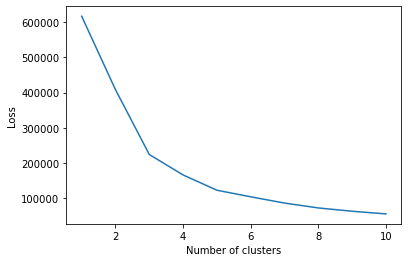

(0.0, 6.0)

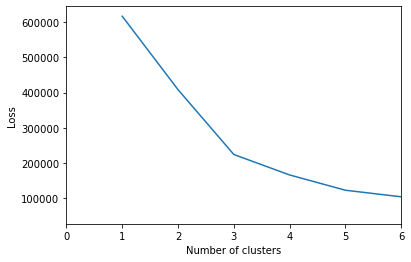

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(hour_set)
X_scaled = scaler.transform(hour_set)
X_scaled_df = pd.DataFrame(X_scaled, columns=hour_set.columns, index=hour_set.index)
X_scaled_df.head()

k_max=10
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,6])

In [32]:
# refit algorithm
two_means = KMeans(n_clusters=3)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [33]:
hour_set.head()

,hour,duration
0,0,21
1,0,20
2,0,19
3,0,22
4,0,45


In [ ]:
numbers = [ "one", "two", "three"]

hour_set["Group"] = two_means.predict(X_scaled)
hour_set["Group"] = hour_set["Group"].apply(lambda x: numbers[x])
sns.pairplot(data=hour_set, hue="Group")


In [ ]:
inverse= scaler.inverse_transform(X_scaled)

In [ ]:
hour_set.max()